<a href="https://colab.research.google.com/github/deansaco/Traffic_Sign_Classifier/blob/main/AlexNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install -q -U keras_tuner

     |████████████████████████████████| 98 kB 2.4 MB/s 


In [2]:
import os
import pickle
import math
import random
import csv
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import numpy as np
import tensorflow as tf
import keras_tuner as kt
from sklearn.utils import shuffle
from tensorflow.keras.layers import Dense, Conv2D, Dropout, ReLU, MaxPool2D, Flatten


print('All modules imported.')

All modules imported.


In [3]:
#mount zip file for google colab gpu use
from google.colab import drive
import os

# Mount Google Drive
drive.mount('/gdrive', force_remount=True)

# Location of Zip File
drive_path = '/gdrive/MyDrive/Traffic-Sign-Classifier-master.zip'
local_path = '/content'

# Copy the zip file and move it up one level (AKA out of the drive folder)
!cp '{drive_path}' .

# Navigate to the copied file and unzip it quietly
os.chdir(local_path)
!unzip -q 'Traffic-Sign-Classifier-master.zip'

Mounted at /gdrive


In [ ]:
#add regulization loss to the model!!!!

# 1 Reload the preprocessed data

In [4]:
# 1 Reload the preprocessed data

pickle_file = '/content/Traffic-Sign-Classifier-master/traffic-signs-data/pre-data.pickle'
with open(pickle_file, 'rb') as f:
    pickle_data = pickle.load(f)
    X_train = pickle_data['train_features']
    y_train = pickle_data['train_labels']
    X_valid = pickle_data['valid_features']
    y_valid = pickle_data['valid_labels']
    X_test = pickle_data['test_features']
    y_test = pickle_data['test_labels']
    signnames = pickle_data['signnames']
    del pickle_data  # Free up memory
    
# Shuffle the data set
X_train, y_train = shuffle(X_train, y_train)
X_valid, y_valid = shuffle(X_valid, y_valid)
X_test, y_test = shuffle(X_test, y_test)

X_train=X_train/255.0
X_valid=X_valid/255.0
X_test=X_test/255.0

print(X_train.shape, y_train.shape)
print(X_valid.shape, y_valid.shape)
print(X_test.shape, y_test.shape)
print(len(signnames))
print('Data loaded.')

(34799, 32, 32, 3) (34799,)
(4410, 32, 32, 3) (4410,)
(12630, 32, 32, 3) (12630,)
43
Data loaded.


In [5]:
# #convert output into one hot encoded vector
y_train = tf.one_hot(y_train, 43)
y_valid = tf.one_hot(y_valid, 43)
y_test = tf.one_hot(y_test, 43)

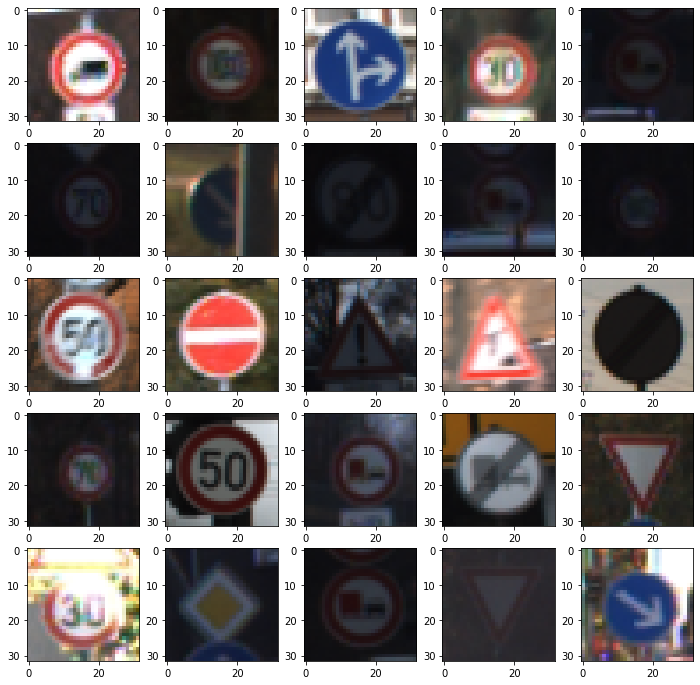

In [6]:
plt.figure(figsize=(12,12))
# plot first few images
for i in range(25):
    # define subplot
    plt.subplot(5, 5, i+1)
    # plot raw pixel data
    plt.imshow(X_train[i], cmap=plt.get_cmap('gray'))
# show the figure
plt.show()

In [18]:
def create_model(hp):
    AlexNet= tf.keras.Sequential(layers=[Conv2D(9,5, activation= ReLU()), 
                            MaxPool2D([2, 2], [2, 2]),
                            Conv2D(32,3, activation= ReLU()),
                            MaxPool2D([2, 2], [2, 2]),
                            Conv2D(48,3, activation= ReLU(), padding='same'),
                            Conv2D(64,3, activation= ReLU(), padding='same'),
                            Conv2D(96,3, activation= ReLU(), padding ='same'),
                            MaxPool2D([2, 2], [2, 2]),
                            Flatten(),
                            Dense(400, activation= ReLU()),
                            Dropout(0.5),
                            Dense(160, activation= ReLU()),
                            Dropout(0.5),
                            Dense(43)
                           ])

    hp_learning_rate=hp.Choice('learning_rate', values=[1e-3, 1e-4, 1e-5])
# Layer 1: Input = 32x32x3. Output = 28x28x9.
# Convolutional. 
# filters (number of output filters) = 9, 
# kernel size (height and width of conv window 5x5) =5, activation function = relu

# Max Pooling. Input = 28x28x9. Output = 14x14x9.
# pool size = 2x2 window, strides = moves 2 in x and 2 in y for each pool step

# Layer 2: Input = 14x14x9. Output = 12x12x32.
# Convolutional. filters = 32, kernel_size=3

# Max Pooling. Input = 12x12x32. Output = 6x6x32.

# Layer 3: Input = 6x6x32. Output = 6x6x48.
# Convolutional. filters = 48, kernel_size=3

# Layer 4: Input = 6x6x48. Output = 6x6x64.
# Convolutional. filters = 64, kernel_size=3

# Layer 5: Input = 6x6x64. Output = 6x6x96.
# Convolutional. filters = 96, kernel_size=3

# Max Pooling. Input = 6x6x96. Output = 3x3x96.

# Flatten. Input = 3x3x96. Output = 864.

# Layer 6: Input = 864. Output = 400.
# Dense: Fully Connected. 
# Dropout: disconnet 20% of connections to prevent overfitting

# Layer 6: Input = 400. Output = 160.
# Dense: Fully Connected. 
# Dropout: disconnet 20% of connections to prevent overfitting

# Layer 6: Input = 160. Output = 43.
# Dense: Fully Connected. 
    
# batch gradient descent optimizer
# optimizer = tf.train.GradientDescentOptimizer(learning_rate = LEARNING_RATE)
# Adam optimizer

    #LEARNING_RATE = tf.keras.optimizers.schedules.ExponentialDecay(1e-2, decay_steps=180, decay_rate=0.96)
    #LEARNING_RATE=5e-4
    
    
    opt = tf.keras.optimizers.Adam(learning_rate=hp_learning_rate, name='Adam')
    loss_function=tf.keras.losses.CategoricalCrossentropy(from_logits=True)
    AlexNet.compile(optimizer=opt,loss=loss_function, metrics=['acc'])
    
    return AlexNet
    

In [19]:
tuner =kt.Hyperband(create_model,
                    objective='val_acc',
                    max_epochs = 40)

INFO:tensorflow:Reloading Oracle from existing project ./untitled_project/oracle.json
INFO:tensorflow:Reloading Tuner from ./untitled_project/tuner0.json


In [20]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [21]:
tuner.search(X_train, y_train, validation_data=(X_test, y_test), epochs=50, callbacks=[stop_early])

best_hps= tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal learning rate for the optimizer is
{best_hps.get('learning_rate')}.
""")

INFO:tensorflow:Oracle triggered exit

The hyperparameter search is complete. The optimal learning rate for the optimizer is
0.0001.



In [22]:
model=tuner.hypermodel.build(best_hps)
history = model.fit(X_train, y_train, 
                         epochs=50, 
                         batch_size=128, 
                         validation_data=(X_test, y_test))

val_acc_per_epoch = history.history['val_acc']
best_epoch=val_acc_per_epoch.index(max(val_acc_per_epoch))+1
print('Best epoch: %d'% (best_epoch,))

Epoch 1/50
272/272 [==============================] - 6s 18ms/step - loss: 3.5108 - acc: 0.0813 - val_loss: 3.1087 - val_acc: 0.2275
Epoch 2/50
272/272 [==============================] - 4s 16ms/step - loss: 2.8156 - acc: 0.2393 - val_loss: 2.2790 - val_acc: 0.3786
Epoch 3/50
272/272 [==============================] - 4s 15ms/step - loss: 2.2105 - acc: 0.3671 - val_loss: 1.8541 - val_acc: 0.4413
Epoch 4/50
272/272 [==============================] - 4s 15ms/step - loss: 1.8177 - acc: 0.4523 - val_loss: 1.5663 - val_acc: 0.5397
Epoch 5/50
272/272 [==============================] - 4s 15ms/step - loss: 1.5288 - acc: 0.5257 - val_loss: 1.2758 - val_acc: 0.6097
Epoch 6/50
272/272 [==============================] - 4s 14ms/step - loss: 1.2922 - acc: 0.5912 - val_loss: 1.0949 - val_acc: 0.6547
Epoch 7/50
272/272 [==============================] - 4s 15ms/step - loss: 1.1213 - acc: 0.6406 - val_loss: 0.9721 - val_acc: 0.7001
Epoch 8/50
272/272 [==============================] - 4s 14ms/step - 

395/395 - 2s - loss: 0.3503 - acc: 0.9245 - 2s/epoch - 4ms/step
Test Accuracy: 92.45447516441345


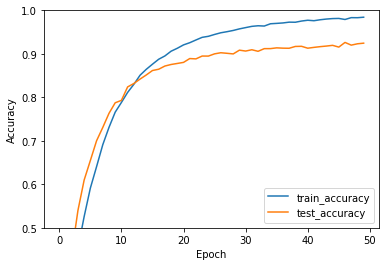

In [23]:
plt.plot(history.history['acc'], label='train_accuracy')
plt.plot(history.history['val_acc'], label = 'test_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

#evaluate model
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=2)

      
print(f'Test Accuracy:', 100*test_accuracy)

In [24]:
hypermodel=tuner.hypermodel.build(best_hps)

checkpoint_path="LeNet_dropout=0.5/cp.ckpt"
checkpoint_dir=os.path.dirname(checkpoint_path)

cp_callback=tf.keras.callbacks.ModelCheckpoint(checkpoint_path, 
                                               save_weights_only=True,
                                               verbose=1)

#LeNetModel=create_model()

#fit model
history = hypermodel.fit(X_train, y_train, 
                         epochs=best_epoch, 
                         batch_size=128, 
                         validation_data=(X_test, y_test),
                         callbacks=[cp_callback])



Epoch 1/47
269/272 [============================>.] - ETA: 0s - loss: 3.5244 - acc: 0.0797
Epoch 00001: saving model to LeNet_dropout=0.5/cp.ckpt
272/272 [==============================] - 6s 18ms/step - loss: 3.5210 - acc: 0.0806 - val_loss: 3.0869 - val_acc: 0.2712
Epoch 2/47
272/272 [==============================] - ETA: 0s - loss: 2.7523 - acc: 0.2644
Epoch 00002: saving model to LeNet_dropout=0.5/cp.ckpt
272/272 [==============================] - 4s 16ms/step - loss: 2.7523 - acc: 0.2644 - val_loss: 2.1517 - val_acc: 0.4214
Epoch 3/47
269/272 [============================>.] - ETA: 0s - loss: 2.0479 - acc: 0.4146
Epoch 00003: saving model to LeNet_dropout=0.5/cp.ckpt
272/272 [==============================] - 4s 16ms/step - loss: 2.0456 - acc: 0.4150 - val_loss: 1.5553 - val_acc: 0.5393
Epoch 4/47
272/272 [==============================] - ETA: 0s - loss: 1.5936 - acc: 0.5221
Epoch 00004: saving model to LeNet_dropout=0.5/cp.ckpt
272/272 [==============================] - 4s 16ms

In [25]:
hypermodel.load_weights(checkpoint_path)
test_loss, test_accuracy = hypermodel.evaluate(X_test, y_test)
valid_loss, valid_accuracy = hypermodel.evaluate(X_valid, y_valid)
train_loss, train_accuracy =hypermodel.evaluate(X_train, y_train)


print("restored model, test accuracy: {:5.2f}%".format(100*test_accuracy))
print("restored model, validation accuracy: {:5.2f}%".format(100*valid_accuracy))

print("restored model, train accuracy: {:5.2f}%".format(100*train_accuracy))

1088/1088 [==============================] - 6s 5ms/step - loss: 0.0081 - acc: 0.9985
restored model, test accuracy: 92.53%
restored model, validation accuracy: 94.17%
restored model, train accuracy: 99.85%


In [ ]:
hypermodel.summary()

395/395 - 2s - loss: 0.3767 - acc: 0.9253 - 2s/epoch - 4ms/step
Test Accuracy: 92.52573251724243


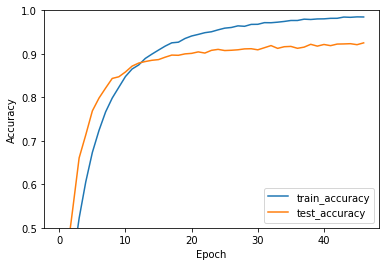

In [26]:
plt.plot(history.history['acc'], label='train_accuracy')
plt.plot(history.history['val_acc'], label = 'test_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

#evaluate model
test_loss, test_accuracy = hypermodel.evaluate(X_test, y_test, verbose=2)

      
print(f'Test Accuracy:', 100*test_accuracy)

predicted sign: Priority road


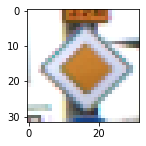

real sign: Priority road




predicted sign: Speed limit (30km/h)


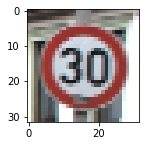

real sign: Speed limit (30km/h)




predicted sign: Turn left ahead


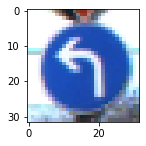

real sign: Turn left ahead




predicted sign: Right-of-way at the next intersection


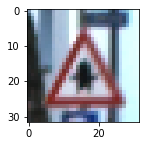

real sign: Right-of-way at the next intersection




predicted sign: No passing


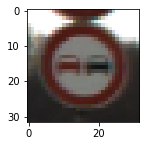

real sign: No passing




predicted sign: No passing


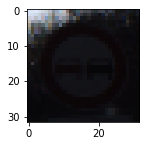

real sign: No passing




predicted sign: Yield


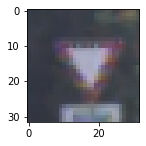

real sign: Yield




predicted sign: Turn right ahead


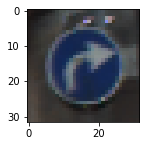

real sign: Turn right ahead




predicted sign: Speed limit (50km/h)


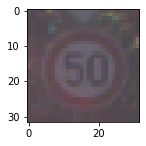

real sign: Speed limit (50km/h)






In [27]:
for i in range(1,10):
    test_image = X_test[i]
    array=np.expand_dims(test_image, axis=0)
    prediction = hypermodel.predict(array)
    prediction= (np.argmax(prediction))
    print("predicted sign:", signnames[prediction])    
    test_label= y_test[i]
    arr=np.expand_dims(test_label, axis=0)
    truth= (np.argmax(arr))
    plt.figure(figsize=(12,12))
    # define subplot
    plt.subplot(5, 5, i+1)
    # plot raw pixel data
    plt.imshow(test_image, cmap=plt.get_cmap('gray'))
    # show the figure
    plt.show()
    print("real sign:", signnames[truth])
    print('\n')
    print('\n')



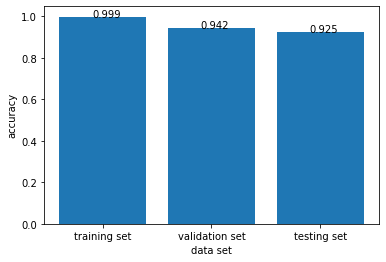

In [28]:
accuracys = [train_accuracy, valid_accuracy, test_accuracy]
tick_labels = ["training set", "validation set", "testing set"]
plt.bar(range(3), accuracys)
plt.xlabel('data set')
plt.ylabel('accuracy')
plt.xticks(range(3), tick_labels)
for x_,y_ in zip(range(3), accuracys):
    plt.text(x_ - 0.1, y_, '%.3f'%y_)
plt.show()

In [29]:
latest = tf.train.latest_checkpoint(checkpoint_dir)
hypermodel.load_weights(latest)


test_loss, test_accuracy = hypermodel.evaluate(X_test, y_test)
print("restored model, test accuracy: {:5.2f}%".format(100*test_accuracy))

395/395 [==============================] - 2s 5ms/step - loss: 0.3767 - acc: 0.9253
restored model, test accuracy: 92.53%
